In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from model.utils import build_spatial_graph, build_connection_graph

from model.Model_Pyg_SpaCon import SpaCon
# from model.r_mcluster import mclust_R
from torch_geometric.loader import NeighborLoader
from model.Similar_Neightbor_Loader import similar_neighbor_loder

import torch.nn.functional as F
import copy
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

import torch
import numpy as np
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

mus = 'mouse_1'
if mus == 'mouse_1':
    plot_x, plot_y = 'z', 'y'
    figsize1 = (5,5)
    figsize2 = (4,5)
elif mus == 'mouse_3':
    plot_x, plot_y = 'x', 'y'
    figsize1 = (11,5)
    figsize2 = (9,5)

#### load adata

In [ ]:
adata = sc.read_h5ad(f'./data/{mus}/adata_merge.h5ad')
print('raw adata shape:', adata.shape)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# build the section list
section_order = np.unique(adata.obs['section']).tolist()
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  rad_cutoff=0.7, rad_cutoff_Zaxis=1.0,
                                            sec_x='x', sec_y='y', key_section='section',
                                            section_order=section_order)
ST_graph_data

In [ ]:
nt_adj = np.load('/mnt/Data18Td/Data/haichao/mouse_connect_data/NT/zxw/mouse_1/zxw_adj.npy')
NT_graph_data = build_connection_graph(adata, nt_adj, threshold=0.001)

In [ ]:
sampling_method = 'neighbor_loader'   # neighbor_loader or similar_neighbor_loder, For particularly large datasets, using similar_neighbor_loder may consume more memory.

if sampling_method == 'neighbor_loader':
    train_loader = NeighborLoader(NT_graph_data, shuffle=False, num_neighbors=[20, 10, 10],
                                  batch_size=32, num_workers=4)
elif sampling_method == 'similar_neighbor_loder':
    # correlation between points
    expression_matrix = adata.X.A
    correlation_matrix = np.corrcoef(expression_matrix)
    np.fill_diagonal(correlation_matrix, 0)
    # train loader
    train_loader = similar_neighbor_loder(NT_graph_data, correlation_matrix, batch_size=32, num_neighbors=[20, 10, 10], beta=0.1)

# evaluate loader
evaluate_loader_con = NeighborLoader(copy.copy(NT_graph_data), input_nodes=None, shuffle=False, num_neighbors=[-1], batch_size=32, num_workers=4)   # test_loader: num_neighbors=[-1]
# Add global node index information.
evaluate_loader_con.data.num_nodes = NT_graph_data.num_nodes
evaluate_loader_con.data.n_id = torch.arange(NT_graph_data.num_nodes)

# evaluate
evaluate_loader_spa = NeighborLoader(copy.copy(ST_graph_data), input_nodes=None, shuffle=False, num_neighbors=[-1], batch_size=32, num_workers=4)   # test_loader: num_neighbors=[-1]
# Add global node index information.
evaluate_loader_spa.data.num_nodes = ST_graph_data.num_nodes
evaluate_loader_spa.data.n_id = torch.arange(ST_graph_data.num_nodes)

epoch:1|4


100%|██████████| 7830/7830 [10:38<00:00, 12.27it/s]


606717963705.6094
epoch:2|4


100%|██████████| 7830/7830 [11:03<00:00, 11.80it/s]


369082052682.2656
epoch:3|4


100%|██████████| 7830/7830 [11:11<00:00, 11.67it/s]


308715753823.5078
epoch:4|4


100%|██████████| 7830/7830 [10:03<00:00, 12.97it/s]


288194521107.8672


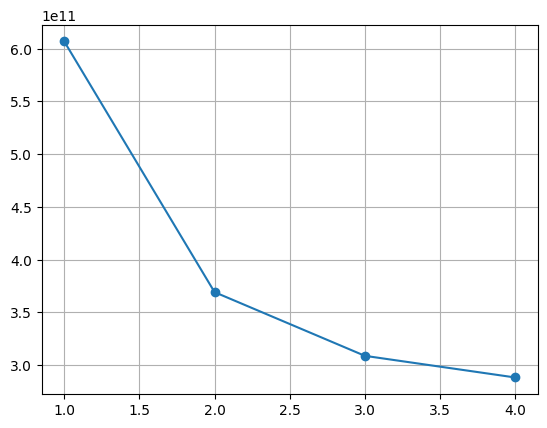

./results_gate_skip_connect/mouse_1/2024_08_13_11_20_51GATE_2encoder_cat_feature_decoder_skip_connect_bn/


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 4
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 64, 16]    
# model
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)

loss_list = []
# for training
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model.train()
for epoch in range(1, num_epoch+1):
    loss_batch = 0
    print(f'epoch:{epoch}|{num_epoch}')
    for batch_NT in tqdm(train_loader):
        # model.train()
        optimizer.zero_grad()
        batch_NT = batch_NT.to(device)
        n_id = batch_NT.n_id.to('cpu').detach().numpy()
        st_adj_batch = st_adj[n_id][:, n_id]
        edgeList = np.argwhere(st_adj_batch)
        f_con, f_spa, re = model(batch_NT.x, batch_NT.edge_index, torch.LongTensor(edgeList.T).to(device))
        loss = F.mse_loss(batch_NT.x, re, reduction="sum") 
        loss_batch += loss.to('cpu').detach().numpy()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
        optimizer.step()
        # break
    loss_list.append(loss_batch)
plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-')
plt.grid(True)
plt.show()

path = f"./results_gate_skip_connect/{mus}/"+str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')+f'GATE_2encoder_cat_feature_decoder_skip_connect_bn/')
os.makedirs(path)
print(path)
torch.save(model.state_dict(), path+'/model_params.pth')

In [6]:
# model evaluate
layer_eval = True

model.eval()
if layer_eval == True:
    feature_con = model.con_inference(NT_graph_data.x, evaluate_loader_con, device=device)
    feature_spa = model.spa_inference(ST_graph_data.x, evaluate_loader_spa, device=device)
    adata.obsm['feature_spa'] = feature_spa.to('cpu').detach().numpy()
    adata.obsm['feature_con'] = feature_con.to('cpu').detach().numpy()
# all data evaluate
else:
    f_con_list = []
    f_spa_list = []
    re_list = []
    for batch_NT in tqdm(evaluate_loader_con):
        batch_NT = batch_NT.to(device)
        n_id = batch_NT.n_id.to('cpu').detach().numpy()
        st_adj_batch = st_adj[n_id][:, n_id]
        edgeList = np.argwhere(st_adj_batch)
        f_con, f_spa, re = model(batch_NT.x, batch_NT.edge_index, torch.LongTensor(edgeList.T).to(device))

        f_con_list.append(f_con[:batch_NT.batch_size].to('cpu').detach().numpy())
        f_spa_list.append(f_spa[:batch_NT.batch_size].to('cpu').detach().numpy())
        re_list.append(re[:batch_NT.batch_size].to('cpu').detach().numpy())

    f_con = np.concatenate(f_con_list, axis=0)
    f_spa = np.concatenate(f_spa_list, axis=0)
    re = np.concatenate(re_list, axis=0)
    adata.obsm['feature_spa'] =f_spa
    adata.obsm['feature_con'] =f_con
    adata.layers['exp_reconstructed'] = re


Evaluating: 100%|██████████| 751605/751605 [01:10<00:00, 10647.52it/s]


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_standard = StandardScaler()
f_con = scaler_standard.fit_transform(adata.obsm['feature_con'])
f_spa = scaler_standard.fit_transform(adata.obsm['feature_spa'])
alp=0
f_alp = (np.exp(-4 * alp) - 1) / (np.exp(-4) - 1)
f_add = f_alp*f_con + (1-f_alp)*f_spa
adata.obsm['feature_add'] = f_add

sc.pp.neighbors(adata, use_rep='feature_add', n_neighbors=40)
sc.tl.umap(adata)

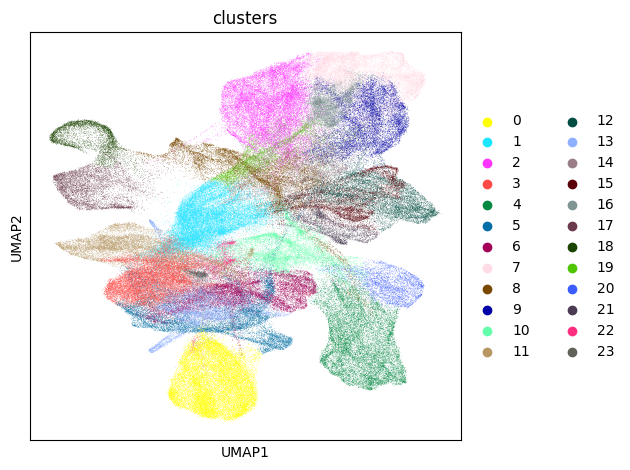

In [11]:
resolution = 0.75
fig_path = path + f'feature_add_weight{alp}/Clusters_res{resolution}/'
os.makedirs(fig_path, exist_ok=True)

sc.tl.louvain(adata,
             resolution=resolution,   # default=1  resolution = k*num (k>0)
             key_added="clusters")
sc.pl.umap(adata,color='clusters', show=False)
plt.tight_layout()
plt.savefig(fig_path+f'umap_res{resolution}.png')
adata.write_h5ad(fig_path+'/adata_cluster_feature.h5ad')

In [12]:
for it, label in enumerate(np.unique(adata.obs['section'])):
    temp_adata = adata[adata.obs['section'] == label, ]
    fig = plt.figure(figsize=figsize1)
    plt.scatter(temp_adata.obs[plot_x].values, temp_adata.obs[plot_y].values, c=temp_adata.obs['clusters'].astype('int').values, cmap='Spectral_r', s=10)  # viridis 绘制样本点
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.savefig(fig_path + '/section_'+str(label)+'.png')
    plt.close() 

for Class_i in tqdm(range(np.unique(np.array(adata.obs['clusters'])).shape[0])):  # adata.shape[0]
    # build the spot_i anndata
    Class_i_adata = adata[adata.obs['clusters']==str(Class_i)]
    # build the save path
    fig_eachclass_path = fig_path+'/cluster_result_eachclass/ClassNum_'+str(Class_i)+'_sameclasssSpotsNum_'+str(Class_i_adata.shape[0])
    if os.path.exists(fig_eachclass_path) == False:
        os.makedirs(fig_eachclass_path)  # build all the folders
    # plot same class as the spoti on every section
    for label in set(Class_i_adata.obs['section'].values):
        adata_section = adata[adata.obs['section'] == label]
        adata_class = Class_i_adata[Class_i_adata.obs['section'] == label]

        fig = plt.figure(figsize=figsize2)
        # plot
        plt.scatter(adata_section.obs[plot_x].values, adata_section.obs[plot_y].values, c='#D3D3D3', s=10)
        plt.scatter(adata_class.obs[plot_x].values, adata_class.obs[plot_y].values, c='#FF6347', s=10)
        plt.gca().invert_yaxis()
        # plt.legend(loc='upper right', prop={'size':5})
        plt.savefig(fig_eachclass_path + '/section_'+str(label)+'.png')
        # plt.show()
        plt.close()

100%|██████████| 24/24 [02:36<00:00,  6.50s/it]
